# Psych 253 Assignment 1
Ashish Mehta - 4.22.20

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. Your code should largely go where specified by the comments, though feel free to include more individual cells within those chunks if that's helpful for you. For more details see the assignment 1 pdf on canvas.*

First, we will import the packages and code modules we will need for the assignment, as well as defining a few key helper functions

In [1]:
#import the plotting library matplotlib
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#other useful imports 
from itertools import product
import numpy as np
import scipy as sp
import scipy.stats as stats
import h5py

In [2]:
#loading code modules 
import metrics 
import cross_validation as cv
from utils import spearman_brown
from utils import featurewise_norm

Here's a link to the dataset we'll be using for this assignment: [ventral neural dataset](https://psych253data.s3-us-west-1.amazonaws.com/ventral_neural_data.hdf5). Warning it's a pretty big download (~4 GB)! If you have problems downloading it, please ask me for help.

In [5]:
#loading the dataset 
DATA_PATH = "data/ventral_neural_data.hdf5" ##YOUR PATH HERE
Ventral_Dataset = h5py.File(DATA_PATH, 'r')

In [6]:
#useful utility function for plotting HDF5 dimension labels
def dimnames(dataset):
    dims = dataset.dims  #get the dimension object
    dimlist = [x.label for x in dims.keys()]  #get the label attribute
    dimlist = map(str, dimlist)  #cast everything to string instead of "unicode" ... complicated rathole ... not strictly necessary
    return dimlist

In [7]:
#here's a very simple implementation of split-half reliability
#this is a NON-boostrapping version

def get_correlation(data_by_trial, num_trials, num_splits):
    """arguments:
          data_by_trial -- (numpy array) the data
             assumes a tensor with structure is (stimuli, trials)
             
          num_trials -- (nonnegative integer) how many trials to consider
          
          num_splits (nonnegative integer) how many splits of the data to make
          
       returns:
          array of length num_splits
    """

    
    #get the total number of trials
    num_total_trials = data_by_trial.shape[1]
    
    #you better not ask for more trials than you actually have
    assert num_trials <= num_total_trials, "You asked for %d trials but there's only %d" % (num_trials, num_total_trials)
    
    #we want to make sure that while we select groups of trials basically randomly,
    #that we can still exactly reproduce our results later
    #so to do this, we use a constructed random number generator to select trial groups
    #and seed the generator with seed = 0 (could be any non-negative integer, but the seed
    #*must* be set for this to be reproducible
    random_number_generator = np.random.RandomState(seed=0)

    corrvals = []
    for split_index in range(num_splits):
        #construct a new permutation of the trial indices
        perm =  random_number_generator.permutation(num_total_trials)
    
        #take the first num_trials/2 and second num_trials/2 pieces of the data
        first_half_of_trial_indices = perm[:num_trials // 2]
        second_half_of_trial_indices = perm[num_trials // 2: num_trials]
        
        #mean over trial dimension
        mean_first_half_of_trials = data_by_trial[:, first_half_of_trial_indices].mean(axis=1)
        mean_second_half_of_trials = data_by_trial[:, second_half_of_trial_indices].mean(axis=1)
        
        #compute the correlation between the means
        corrval = stats.pearsonr(mean_first_half_of_trials, mean_second_half_of_trials)[0]
        #add to the list
        corrvals.append(corrval)
        
    return np.array(corrvals)

In [8]:
def get_reliability_spearman_brown(data, num_trials):
    """
    This is a convenience function that gets us the reliability (Spearman-Brown corrected) for some data and number of trials
    
    arguments:
       data -- (numpy array) of shape (stimuli, trials)
    
    """
    means = []
    sems = []
    corrected_means = []
    
    #determine the total number of trials
    total_num_trials = data.shape[1]
    
    #we'll evaluate reliability for this total number of trials
    cs = get_correlation(data, num_trials, 10 * num_trials) #we'll determine below that having num_splits ~ 10 * num trials is good enough
    
    mean = cs.mean()
    sem = cs.std() / np.sqrt(10 * num_trials)
    multiple = total_num_trials / float(num_trials) #have to do "float" here since python 2.x does integer division
    corrected_mean = spearman_brown(mean, multiple) 
    
    return corrected_mean

# 1.1 Data wrangling and Python practice

In [9]:
#We'll start with some set up and exploration

#First, what is in the dataset
list(Ventral_Dataset.keys())

['image_meta',
 'images',
 'neural_meta',
 'time_averaged',
 'time_averaged_trial_averaged',
 'time_binned',
 'time_binned_trial_averaged']

In [325]:
# TODO:                                                                        
# Okay, what about a level below in the data structure
# i.e. what are the keys for the image_meta data
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

print(list(Ventral_Dataset['image_meta'].keys()))
print(list(Ventral_Dataset['neural_meta'].keys()))
print(list(Ventral_Dataset['time_averaged'].keys()))
print(list(Ventral_Dataset['time_binned'].keys()))

# print(Ventral_Dataset['time_averaged_trial_averaged'])


print(len(list(Ventral_Dataset['neural_meta']['ANIMAL_INFO'])))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

['category', 'object_name', 'rotation_xy', 'rotation_xz', 'rotation_yz', 'size', 'translation_y', 'translation_z', 'variation_level']
['AIT_NEURONS', 'ANIMAL_INFO', 'ARRAY_INFO', 'CIT_NEURONS', 'IT_NEURONS', 'PIT_NEURONS', 'V4_NEURONS']
['variation_level_0', 'variation_level_3', 'variation_level_6']
['0ms', '100ms', '120ms', '140ms', '160ms', '180ms', '200ms', '20ms', '40ms', '60ms', '80ms']
296


In [11]:
#We'll start with some set up and exploration

#Let's get the IT neural data -- time and trial averaged
Neural_Data = Ventral_Dataset['time_averaged_trial_averaged'][:]

IT_NEURONS = Ventral_Dataset['neural_meta']['IT_NEURONS']
IT_Neural_Data = Neural_Data[:, IT_NEURONS]

#... and remind ourselves of the tensor shape
print('Shape:', IT_Neural_Data.shape) #num images x num neurons

Shape: (5760, 168)


In [12]:
# TODO:                                                                        
# Okay, now get the same type of neural data for V4
# Following code will assume you called the neurons 
# V4_NEURONS and the neural data V4_Neural_Data
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

V4_NEURONS = Ventral_Dataset['neural_meta']['V4_NEURONS']
V4_Neural_Data = Neural_Data[:, V4_NEURONS]

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

In [13]:
#Get the different variation levels to use for indexing
var_level = Ventral_Dataset['image_meta']['variation_level']
unique_var_levels = np.unique(var_level)
print(unique_var_levels)

[b'V0' b'V3' b'V6']


In [14]:
#Let's check what the different keys are
list(Ventral_Dataset['time_averaged'].keys())

['variation_level_0', 'variation_level_3', 'variation_level_6']

In [15]:
#Okay now we can use unique_var_levels and what we learnt in the cell above
#to get the data by trial for the time-averaged responses
data_by_trial = {}
for vl in unique_var_levels:
    level_number = vl.decode("utf-8") #in python 3 these are byte strings so we need to decode them
    arr = Ventral_Dataset['time_averaged']['variation_level_%s' % level_number[-1]][:, :, :]
    data_by_trial[level_number] = arr.swapaxes(0,1) #swap axes to match format required by get_correlation

In [190]:
#How many trials are there?

#First, what are the different dimensions of our data by trials for one variation level 
print(list(Ventral_Dataset['time_averaged']['variation_level_3'].dims.keys()))

#Let's check the number of trials for variation level 0 against the number given in the assignment PDF (28)
#(Remember we swapped the axes for data_by_trial)
num_trials_V0 = data_by_trial['V0'].shape[1]
print(data_by_trial['V0'].shape)
print(num_trials_V0)

[<"trial" dimension 0 of HDF5 dataset at 112476233048>, <"image" dimension 1 of HDF5 dataset at 112476233048>, <"neuron" dimension 2 of HDF5 dataset at 112476233048>]
(640, 28, 296)
28


In [80]:
# TODO:                                                                        
# Create a variable for the number of neurons called 'num_neurons'
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

num_neurons = Neural_Data.shape[1]
print(num_neurons)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

296


# 1.2 Reliability

## 1.2.1 Problem 1: Reliability computation on time-averaged responses

### Reliability of each neuron
In this problem, we would like you to first compute the reliability for each neuron and variation level using the methods described in the class (specifically, split-half reliability and the Spearman-Brown correction prediction), and then perform a significance test on the population of all the neurons to determine whether the population is significantly reliable or not.

Before we launch into this problem, let's test a few things and confirm some of our earlier choices:

In [18]:
#first I'll test out the split-half reliability on one neuron with one split just to make sure it's working
neuron_ind = 10 #rando neuron
num_splits = 1

corrmeans_by_var_level = []
for vl in unique_var_levels:
    level_number = vl.decode("utf-8")
    num_trials = data_by_trial[level_number].shape[1] #use all trials for each level
    cs = get_correlation(data_by_trial[level_number][:, :, neuron_ind], num_trials, num_splits)

    corrmeans_by_var_level.extend([cs])
    
print(corrmeans_by_var_level)

[array([0.84145457], dtype=float32), array([0.95104754], dtype=float32), array([0.93814296], dtype=float32)]


In that test we used one split but how many splits should we be using in reality? In our get_reliability_spearman_brown function we set the number of splits to be 10 times the num of trials. Let's see how we got that number...

(-1, 513)

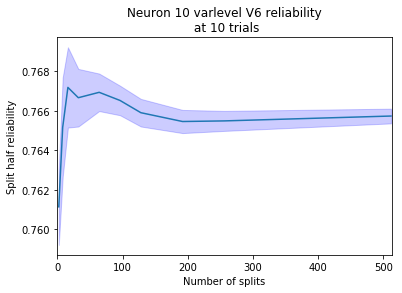

In [18]:
# let's plot reliability estimate and the SEM as a function of the number of splits
neuron_ind = 10
vl = 'V6'
num_splits = [2, 8, 16, 32, 64, 96, 128, 192, 256, 512]

#... first for 10 trials
num_trials = 10

means = []
sems = []

for ns in num_splits:
    cs = get_correlation(data_by_trial[vl][:, :, neuron_ind],
                           num_trials, 
                           ns)
    mean = cs.mean()
    means.append(mean)
    sem = cs.std() / np.sqrt(ns)
    sems.append(sem)
    
means = np.array(means)
sems = np.array(sems)

plt.plot(num_splits, means)
plt.fill_between(num_splits, means - sems, means + sems, color='b', alpha = 0.2)
plt.xlabel('Number of splits')
plt.ylabel('Split half reliability')
plt.title('Neuron %d varlevel %s reliability\n at %d trials' % (neuron_ind, vl, num_trials))
plt.xlim(-1, 513)

(-1, 513)

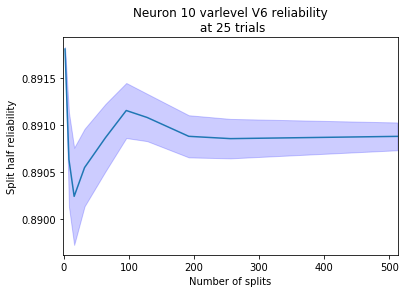

In [19]:
#... and then 25
num_trials = 25

means = []
sems = []

for ns in num_splits:
    cs = get_correlation(data_by_trial[vl][:, :, neuron_ind],
                           num_trials, 
                           ns)
    mean = cs.mean()
    means.append(mean)
    sem = cs.std() / np.sqrt(ns)
    sems.append(sem)
    
means = np.array(means)
sems = np.array(sems)

plt.plot(num_splits, means)
plt.fill_between(num_splits, means - sems, means + sems, color='b', alpha = 0.2)
plt.xlabel('Number of splits')
plt.ylabel('Split half reliability')
plt.title('Neuron %d varlevel %s reliability\n at %d trials' % (neuron_ind, vl, num_trials))
plt.xlim(-1, 513)

Okay, it looks like having num_splits ~ 10 * num_trials is good enough for a stable approximation of reliability so we'll use that rough rule of thumb from now on.

In [345]:
# TODO:                                                                        
# Compute the split-half reliability for the neurons
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

from itertools import product

reliabilities_r = {'V0': [], 'V3': [], 'V6': []}

for vl, neuron_ind in product(unique_var_levels, np.arange(num_neurons)):
    level_number = vl.decode("utf-8")
    num_trials = data_by_trial[level_number].shape[1] 
    num_splits = num_trials*10
    cs = get_correlation(data_by_trial[level_number][:, :, neuron_ind], num_trials, num_splits)

    reliabilities_r[level_number].append(cs.mean())

print({x: np.mean(reliabilities_r[x]) for x in reliabilities_r})


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

{'V0': 0.5152677, 'V3': 0.64800626, 'V6': 0.56669605}


In [519]:
# TODO:                                                                        
# Compute the reliability of the neurons with the Spearman-Brown prediction
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
reliabilities_sb = {'V0': [], 'V3': [], 'V6': []}

for vl, neuron_ind in product(unique_var_levels, np.arange(num_neurons)):
    level_number = vl.decode("utf-8")
    num_trials = 10
    cs = get_reliability_spearman_brown(data_by_trial[level_number][:, :, neuron_ind], num_trials)
    reliabilities_sb[level_number].append(cs.mean())
    
print({x: np.mean(reliabilities_sb[x]) for x in reliabilities_sb})


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

{'V0': 0.5146005669238829, 'V3': 0.6479513827938692, 'V6': 0.5653338557894885}


#### Inline question 1:
Please describe your methods for computing reliability and results.

<span style="color:blue">Your answer:</span>
First, I computed the reliability of each neuron's response to each stimulus using Pearson's r. I then took the mean reliability across all the stimuli of each variation level. The function `get_correlation()` divides the data in half a given number of times (10 * number of trials) and computes the correlation between the means of the two halves. Next, I did a similar process, but instead of dividing all the data in half, I used only 10 trials per neuron/variation level and adjusted the reliability estimate to apply to the whole dataset using a Spearman-Brown correction. Using both methods yielded similar reliabilities with means across neurons in the range of 0.51-0.64.


### Reliability by areas

Now that you’ve gotten a reliability measure for each neuron, choose reliability from one (any) method and use this to test whether reliability of V4 neurons is significantly different from that of IT neurons. You can find the indexes of V4 neurons and IT neurons in the dataset, and as discussed in class. 

In [520]:
# TODO:                                                                        
# Compute the reliability for V4 vs. IT neurons
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)****

import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd

reliabilities_it = {'V0': [], 'V3': [], 'V6': []}
reliabilities_it['V0'] = [reliabilities_sb['V0'][i] for i in list(IT_NEURONS)]
reliabilities_it['V3'] = [reliabilities_sb['V3'][i] for i in list(IT_NEURONS)]
reliabilities_it['V6'] = [reliabilities_sb['V6'][i] for i in list(IT_NEURONS)]

reliabilities_v4 = {'V0': [], 'V3': [], 'V6': []}
reliabilities_v4['V0'] = [reliabilities_sb['V0'][i] for i in list(V4_NEURONS)]
reliabilities_v4['V3'] = [reliabilities_sb['V3'][i] for i in list(V4_NEURONS)]
reliabilities_v4['V6'] = [reliabilities_sb['V6'][i] for i in list(V4_NEURONS)]

print({x: np.mean(reliabilities_it[x]) for x in reliabilities_it})
print({x: np.mean(reliabilities_v4[x]) for x in reliabilities_v4})

# create dataframe
df_it = pd.DataFrame(reliabilities_it)
df_it['area'] = 'it'
df_v4 = pd.DataFrame(reliabilities_v4)
df_v4['area'] = 'v4'
df = pd.concat([df_it, df_v4], ignore_index = True)

# wide to long
df = pd.melt(df, id_vars='area', value_vars=['V0', 'V3', 'V6'], 
             value_name='reliability', 
             var_name='variation_level')
# dummy variable, 0 = it, 1 = v4
df['v4_dummy'] = pd.get_dummies(df['area'], drop_first=True)

#-- mixed effects model -- # 
mod_mix = smf.mixedlm('reliability ~ v4_dummy', df, groups=df['variation_level'])
mod_mix_fit = mod_mix.fit()
print(mod_mix_fit.summary())

# # -- ols model -- #
# design_mat = pd.concat([pd.get_dummies(df['area'], drop_first=True), 
#                    pd.get_dummies(df['variation_level'], drop_first=True)],
#                  axis=1)
# mod_simp = sm.OLS(df['reliability'], design_mat)
# mod_simp_fit = mod_simp.fit()
# print(mod_simp_fit.summary())

# # -- ols model with no variation level -- #
# design_mat = pd.get_dummies(df['area'], drop_first=True)
# mod_simp2 = sm.OLS(df['reliability'], design_mat)
# mod_simp2_fit = mod_simp2.fit()
# print(mod_simp2_fit.summary())

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

{'V0': 0.5504015689453671, 'V3': 0.6418228186371879, 'V6': 0.5972312524139798}
{'V0': 0.467611751770685, 'V3': 0.6559951232495135, 'V6': 0.5234685227198435}
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: reliability
No. Observations: 888     Method:             REML       
No. Groups:       3       Scale:              0.0724     
Min. group size:  296     Likelihood:         -102.7781  
Max. group size:  296     Converged:          Yes        
Mean group size:  296.0                                  
----------------------------------------------------------
           Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept   0.596     0.040  15.047  0.000   0.519   0.674
v4_dummy   -0.047     0.018  -2.605  0.009  -0.083  -0.012
Group Var   0.004     0.017                               



/Users/ashish/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Note that V4 and IT have different numbers of neurons in this experiment. Test the reliability of neurons in the two areas again, subsampling neurons from each area to account for this difference. 

In [521]:
# TODO:                                                                        
# Compute the reliability with subsampling
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

df_n100 = pd.concat([df_it.sample(n=100, replace=False, random_state=0), 
                     df_v4.sample(n=100, replace=False, random_state=0)], 
                    ignore_index = True)

# wide to long
df_n100 = pd.melt(df_n100, id_vars='area', value_vars=['V0', 'V3', 'V6'], 
             value_name='reliability', 
             var_name='variation_level' )
# dummy variable, 0 = it, 1 = v4
df_n100['v4_dummy'] = pd.get_dummies(df_n100['area'], drop_first=True)

#-- mixed effects model -- # 
mod_mix = smf.mixedlm('reliability ~ v4_dummy', df_n100, groups=df_n100['variation_level'])
mod_mix_fit = mod_mix.fit()
print(mod_mix_fit.summary())



# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: reliability
No. Observations: 600     Method:             REML       
No. Groups:       3       Scale:              0.0750     
Min. group size:  200     Likelihood:         -82.2650   
Max. group size:  200     Converged:          Yes        
Mean group size:  200.0                                  
----------------------------------------------------------
           Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept   0.598     0.039  15.224  0.000   0.521   0.675
v4_dummy   -0.048     0.022  -2.141  0.032  -0.092  -0.004
Group Var   0.004     0.016                               



/Users/ashish/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Plot a bar chart showing the mean and standard deviations of reliabilities for V4 and IT. 

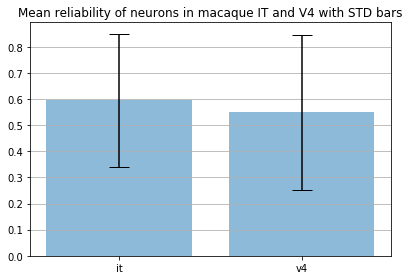

In [522]:
# TODO:                                                                        
# Plot bar chart
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****



means = (np.mean(df.loc[df['area']=='it', 'reliability']), 
         np.mean(df.loc[df['area']=='v4', 'reliability']))
positions = [0, 1]
std = (np.std(df.loc[df['area']=='it', 'reliability'], ddof=1), 
       np.std(df.loc[df['area']=='v4', 'reliability'], ddof=1))


# Build the plot
fig, ax = plt.subplots()
ax.bar(positions, means, yerr=std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('')
ax.set_xticks(positions)
ax.set_xticklabels(['it', 'v4'])
ax.set_title('Mean reliability of neurons in macaque IT and V4 with STD bars')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
plt.show()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

To get an intuitive understanding of the potential differences between the areas, also plot a histogram of the reliability of the neurons in the two areas.

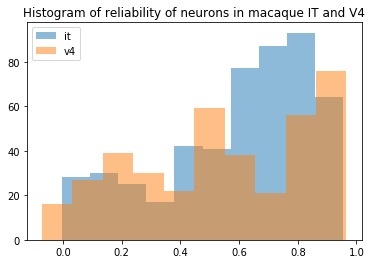

In [523]:
# TODO:                                                                        
# Plot histogram
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

fig, ax = plt.subplots()
ax.hist(df.loc[df['area']=='it', 'reliability'], alpha=0.5, label='it')
ax.hist(df.loc[df['area']=='v4', 'reliability'], alpha=0.5, label='v4')
ax.legend(loc='upper left')
ax.set_title('Histogram of reliability of neurons in macaque IT and V4')
plt.show()


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#### Inline question 2:
Please summarize what you've found here.


<span style="color:blue">Your answer:</span> V4 is slightly less reliable ($\beta$ = -.05, $p$ = .032) than IT. There is also greater variability in the reliability of neurons in V4. IT neurons are mostly above .4, whereas V4 neurons cover a range of reliabilities. Subsampling a portion of neurons did not make a substantive difference in the estimates.

### Reliability by animals

We also would like to validate that neurons in each animal are generating reliable responses. After grouping neurons by animals, test if there is a significant difference in reliability between the two animals. 

In [528]:
# TODO:                                                                        
# Compute the reliability for Chabo vs. Tito
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

df_animal = pd.DataFrame(reliabilities_sb)

df_animal['animal'] = [x.decode('utf-8') for x in Ventral_Dataset['neural_meta']['ANIMAL_INFO']]
df_animal = df_animal.melt(id_vars='animal', var_name='variation_level', value_name='reliability')
df_animal['tito_dummy'] = pd.get_dummies(df_animal['animal'], drop_first=True)
print(df_animal[['animal', 'reliability']].groupby('animal').mean())
print(df_animal[['animal', 'reliability']].groupby('animal').std())


#-- mixed effects model -- # 
mod_mix = smf.mixedlm('reliability ~ tito_dummy', df_animal, groups=df_animal['variation_level'])
mod_mix_fit = mod_mix.fit()
print(mod_mix_fit.summary())


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        reliability
animal             
Chabo      0.662151
Tito       0.510294
        reliability
animal             
Chabo      0.271463
Tito       0.259540
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: reliability
No. Observations: 888     Method:             REML       
No. Groups:       3       Scale:              0.0672     
Min. group size:  296     Likelihood:         -70.2717   
Max. group size:  296     Converged:          Yes        
Mean group size:  296.0                                  
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.662    0.040 16.507 0.000  0.584  0.741
tito_dummy     -0.152    0.018 -8.647 0.000 -0.186 -0.117
Group Var       0.004    0.017                           



/Users/ashish/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


#### Inline question 3:
Please summarize what you've found here.


<span style="color:blue">Your answer:</span> Measurements of Tito's neurons are less reliable than Chabo's ($\beta = -.15, p < .001$)

Plot a histogram of reliability of neurons in two animals.

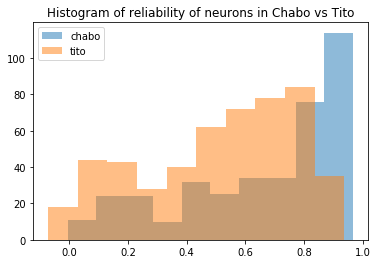

In [525]:
# TODO:                                                                        
# Plot histogram
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

fig, ax = plt.subplots()
ax.hist(df_animal.loc[df_animal['animal']=='Chabo', 'reliability'], alpha=0.5, label='chabo')
ax.hist(df_animal.loc[df_animal['animal']=='Tito', 'reliability'], alpha=0.5, label='tito')
ax.legend(loc='upper left')
ax.set_title('Histogram of reliability of neurons in Chabo vs Tito')
plt.show()


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

## 1.2.1 Problem 2: Reliability computation on 20ms responses

Although we might have confirmed the quality of this dataset through computing reliability on time-averaged neural responses, this process of time-averaging could conceal low-quality data by combining both high- and low-quality data. Therefore, in this problem, we will work on time-binned neural responses which are closer to the most original experimental data. Specifically:

### Reliability by area in each 20ms bin

Please first compute reliability for every neuron on data from each of the 20ms bins from 0ms to 200ms post stimulus presentation. The time binned neural data is stored in the dataset using key “time binned”. One interesting pattern to investigate is how the reliabilities vary across time, especially whether this pattern differs between neurons in V4 and IT. Hence, please group the reliabilities of neurons for V4 and IT respectively for different time bins and then plot the timecourse of reliabilities for these areas in the same plot. 

In [435]:
# TODO:                                                                        
# Calculate reliability by bin and then sort by V4 and IT
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# data_by_trial = {}
# for vl in unique_var_levels:
#     level_number = vl.decode("utf-8") #in python 3 these are byte strings so we need to decode them
#     arr = Ventral_Dataset['time_binned']['variation_level_%s' % level_number[-1]][:, :, :]
#     dbt[level_number] = arr.swapaxes(0,1) #swap axes to match format required by get_correlation



time_bin_keys = list(Ventral_Dataset['time_binned'].keys())
var_level_keys = [x.decode('utf-8') for x in unique_var_levels]

# Ventral_Dataset['time_binned']['0ms']['variation_level_0']

# reliabilities_bin = {'V0': [], 'V3': [], 'V6': []}


df_time = pd.DataFrame(product(var_level_keys, np.arange(num_neurons), time_bin_keys))
df_time.columns = ['variation_level', 'neuron_ind', 'time_bin']
df_time['reliability'] = np.NaN

for vl, neuron_ind, time_bin in product(var_level_keys, np.arange(num_neurons), time_bin_keys):
    num_trials = 10
    dat = Ventral_Dataset['time_binned'][time_bin]['variation_level_%s' % vl[-1]][:, :, :]
    dat = dat.swapaxes(0,1)
    cs = get_reliability_spearman_brown(dat[:, :, neuron_ind], num_trials)
    df_time.loc[(df_time['variation_level'] == vl) & 
                (df_time['time_bin'] == time_bin) &
                (df_time['neuron_ind'] == neuron_ind), 
                'reliability'] = cs.mean()

print(df_time)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

     variation_level  neuron_ind time_bin  reliability
0                 V0           0      0ms     0.003528
1                 V0           0    100ms     0.128692
2                 V0           0    120ms     0.096257
3                 V0           0    140ms     0.193059
4                 V0           0    160ms     0.201757
5                 V0           0    180ms     0.151536
6                 V0           0    200ms     0.086815
7                 V0           0     20ms     0.004403
8                 V0           0     40ms     0.050043
9                 V0           0     60ms    -0.049048
10                V0           0     80ms     0.070234
11                V0           1      0ms     0.018040
12                V0           1    100ms     0.416164
13                V0           1    120ms     0.356578
14                V0           1    140ms     0.414740
15                V0           1    160ms     0.323826
16                V0           1    180ms     0.336321
17        

In [447]:

df_time['ms'] = df_time['time_bin'].map(lambda x: int(x.rstrip('ms')))
df_time['area'] = ['v4' if (x in list(V4_NEURONS)) else 'it' for x in df_time['neuron_ind']]
df_time = df_time.sort(columns='area').reset_index()


,variation_level,neuron_ind,time_bin,reliability,ms,area
0,V0,0,0ms,0.003528,0,it
1,V0,0,100ms,0.128692,100,it
2,V0,0,120ms,0.096257,120,it
3,V0,0,140ms,0.193059,140,it
4,V0,0,160ms,0.201757,160,it
5,V0,0,180ms,0.151536,180,it
6,V0,0,200ms,0.086815,200,it
7,V0,0,20ms,0.004403,20,it
8,V0,0,40ms,0.050043,40,it
9,V0,0,60ms,-0.049048,60,it


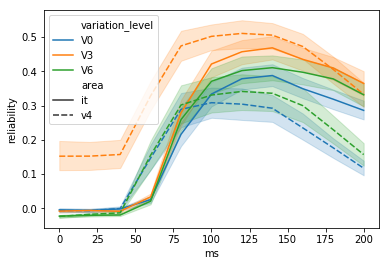

In [529]:
# TODO:                                                                        
# Plot the timecourse of reliabilities for these areas in the same plot
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

import seaborn as sns

sns.lineplot(data=df_time, x='ms', y='reliability', hue='variation_level', style='area')

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

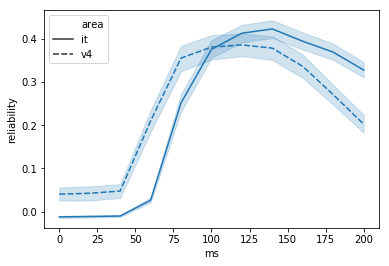

In [453]:

sns.lineplot(data=df_time, x='ms', y='reliability', style='area')

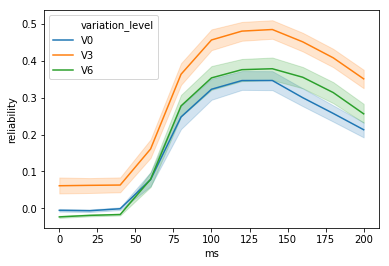

In [454]:

sns.lineplot(data=df_time, x='ms', y='reliability', hue='variation_level')

#### Inline question 4:
Describe your findings. Do you think everything is OK in the data? If not, explain what you find abnormal and why. If you think everything’s OK, please check the hint in the assignment PDF.


<span style="color:blue">Your answer:</span> It is abnormal that reliability starts at around 0 and rises to a peak then drops off again as time goes on. It also appears that V4 increases in reliability earlier than IT, but does not increase to as high of a peak.

### Diagnose the problem

OK, let’s face reality: There must be something wrong in our data! Given the reliabilities for all neurons in all time bins, how should we locate this problem? What will you try to diagnose it? Please show your efforts here and explain your motivations behind these efforts. If you find it difficult to continue, we have provided you hints in the PDF

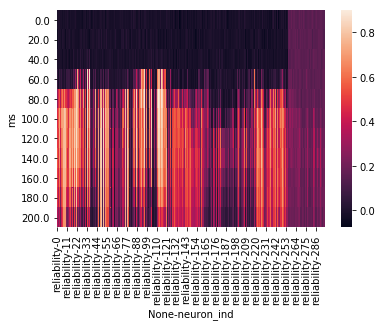

In [484]:
# TODO:                                                                        
# Diagnose the problem
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# First, I will try a heatmap to look for anomalies in the reliability in particular neurons or particular time bins.
df_time_g = df_time[['neuron_ind', 'ms', 'reliability']].groupby(['neuron_ind', 'ms']).mean().unstack(level=0)
df_time_g
sns.heatmap(data=df_time_g)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

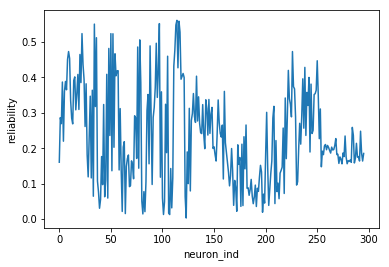

In [530]:
# Now I will use a lineplot to identify if there are particular neurons that are problematic.
df_time_g2 = df_time[['neuron_ind','reliability']].groupby(['neuron_ind']).mean()
df_time_g2['neuron_ind'] = df_time_g2.index
sns.lineplot(data=df_time_g2, x='neuron_ind', y='reliability')

In [541]:
# Now I will record which neurons have decent reliability  
decent_reliability = df_time_g2.loc[df_time_g2['reliability'] > .3, 'neuron_ind']


#### Inline question 5:
Report what you've found.


<span style="color:blue">Your answer:</span> Prior to about 75 ms in V4 and 10 ms in IT, reliability is extremely low. Reliability drops off around 160 ms in both areas. Additionally, it appears there are certain neurons that have low reliability in general in any time bin.

### Difference in V4 and IT neurons

Finally, exclude the wrong part of the data in the following analyses. Redraw the first plot you had for this problem (Section: Reliability by area in each 20ms bin). Describe and interpret your findings. How do V4 and IT differ in terms of when in time they become reliable? Or when reliability fades? What might any differences between V4 and IT you find mean neuroscientifically?

In [543]:
# TODO:                                                                        
# Exclude the problem data
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

df_time_2 = df_time.loc[((df_time['ms']>=75) & (df_time['area']=='v4') & (df_time['ms']<=120) |
                        (df_time['ms']>=100) & (df_time['area']=='it') & (df_time['ms']<=160)) &
                        (df_time['neuron_ind'].isin(decent_reliability)),:]
df_time_2

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

,variation_level,neuron_ind,time_bin,reliability,ms,area
34,V0,3,100ms,0.725479,100.0,it
35,V0,3,120ms,0.638169,120.0,it
36,V0,3,140ms,0.533344,140.0,it
37,V0,3,160ms,0.411983,160.0,it
56,V0,5,100ms,0.505762,100.0,it
57,V0,5,120ms,0.336027,120.0,it
58,V0,5,140ms,0.246366,140.0,it
59,V0,5,160ms,0.249259,160.0,it
67,V0,6,100ms,0.600716,100.0,it
68,V0,6,120ms,0.519382,120.0,it


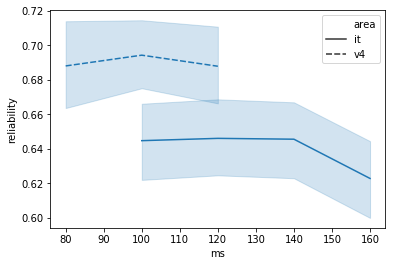

In [544]:
# TODO:                                                                        
# Redraw the plot
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

sns.lineplot(data=df_time_2, x='ms', y='reliability', style='area')

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#### Inline question 6:
Describe and interpret your findings. How do V4 and IT differ in terms of when in time they become reliable? Or when reliability fades? What might any differences between V4 and IT you find mean neuroscientifically?

<span style="color:blue">Your answer:</span> By including only the best performing time bins and neurons, the reliability is substantially improved. V4 has its most reliable time period about 20-40 ms before IT and fades similarly earlier. This makes sense neuroscientifically since one would expect reliability across trials to be highest when the stimuli is having its maximal impact on the neurons. Since V4 is earlier in visual processing, V4 should experience its peak reliability earlier than IT.

In [35]:
#Close the dataset
Ventral_Dataset.close()

You're done with Assignment 1!